## Genearte, Plug-in, and Validate Carbon Yield Cuvres in a Single-stand Test Model

### Set Up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

### Create and Run `ForestModel` Instance

In [3]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
import numpy as np
import libcbm

In [4]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [5]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_test',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [6]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

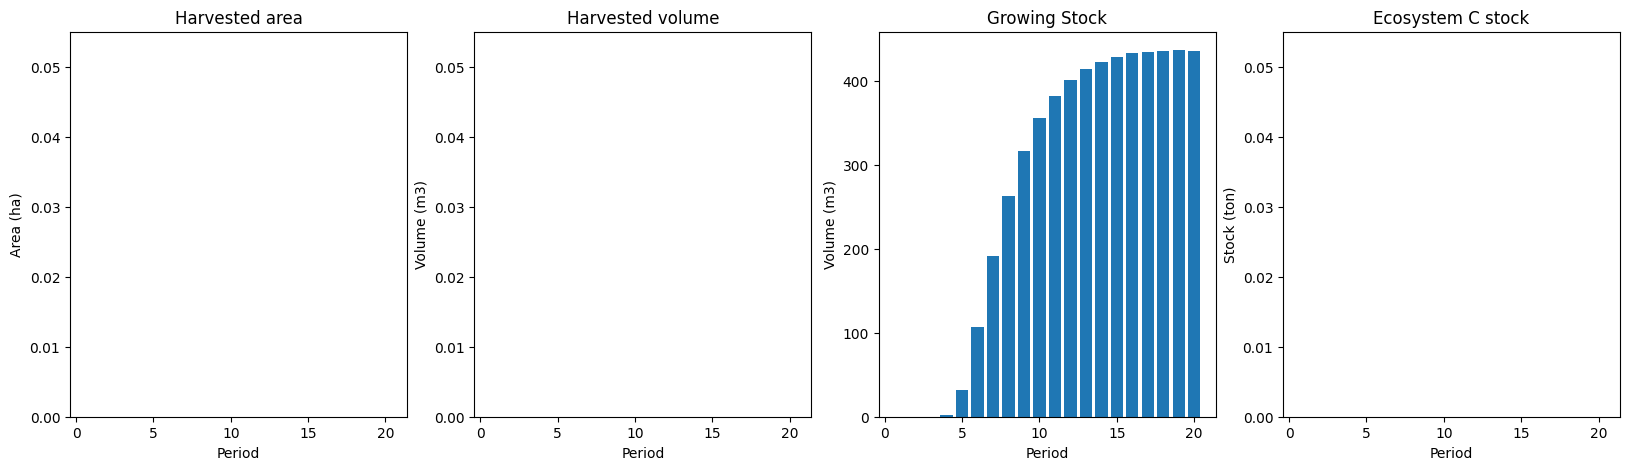

In [7]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

### Hard-link `ForestModel` to `libcbm`

Prepare libcbm input files

In [8]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [9]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

In [11]:
# Run CBM and Generate CBM 0utputs
from util import run_cbm
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [12]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [13]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [14]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

### Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [15]:
sit_events = sit_tables['sit_events']

In [16]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [17]:
sit_inventory = sit_tables['sit_inventory']

In [18]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,1,2403002,204,2423002,softwood,FALSE,1,1.0,0,0,fire,harvest


In [19]:
# Set Age and Area to 0 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [20]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,1,2403002,204,2423002,softwood,FALSE,1,1.0,0,0,fire,harvest


In [21]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [22]:
# Run libcbm and Generate libcbm outputs
cbm_output_curves = run_cbm(sit_config, sit_tables, n_steps=700)

Set the timestep as 700 years to generate a 700-year-long carbon yield curve to simulate the old forest stand's (e.g., 500 years) carbon dynamics in the next 200-year simulation horizon.

In [23]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [24]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [25]:
# Generate Carbon Pool and Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [26]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [27]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 1 2403002 204 2423002 0              0.000002         0.000266   
                            1              0.000032         0.002409   
                            2              0.000180         0.008716   
                            3              0.000616         0.021651   
                            4              0.001597         0.043768   
...                                             ...              ...   
                            696           92.723531         8.635211   
                            697           92.723531         8.635211   
                            698           92.723531         8.635211   
                            699           92.723531         8.635211   
                            700           92.723531         8.635211   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 1 2403002 204 2423002 0              0.000000             0.000034   
                            1              0.000000             0.000311   
                            2              0.000000             0.001134   
                            3              0.000000             0.002839   
                            4              0.000000             0.005785   
...                                             ...                  ...   
                            696           32.241928            27.228756   
                            697           32.241928            27.228756   
                            698           32.241928            27.228756   
                            699           32.241928            27.228756   
                            700           32.241928            27.228756   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 1 2403002 204 2423002 0                  0.000025            0.0   
                            1                  0.000231            0.0   
                            2                  0.000841            0.0   
                            3                  0.002105            0.0   
                            4                  0.004286            0.0   
...                                                 ...            ...   
                            696                2.430592            0.0   
                            697                2.430592            0.0   
                            698                2.430592            0.0   
                            699                2.430592            0.0   
                            700                2.430592            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 1 2403002 204 2423002 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
                            696                   0.0            0.0   
                            697                   0.0            0.0   
                            698                   0.0            0.0   
                            699                   0.0            0.0   
                            700                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 1 2403002 204 2423002 0                       

In [28]:
# Save curves to a pickle file
c_curves_p.to_pickle("curves/c_curves_p.pkl")

In [29]:
c_curves_f['total_emission'] = c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [30]:
# Update the values of timestep 0 to be equal to timestep 1
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [31]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            696                            0.0   
                            697                            0.0   
                            698                            0.0   
                            699                            0.0   
                            700                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            696                            0.0   
                            697                            0.0   
                            698                            0.0   
                            699                            0.0   
                            700                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 1 2403002 204 2423002 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
                            696                           0.0   
                            697                           0.0   
                            698                           0.0   
                            699                           0.0   
                            700                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            696                             0.0   
                            697                             0.0   
                            698                             0.0   
                            699                             0.0   
                            700                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            696                             0.0   

In [32]:
# Save curves to pickle file
c_curves_f.to_pickle("curves/c_curves_f.pkl")

Plug-in carbon yield curves

In [33]:
from util import plugin_c_curves
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

found match for mask ('?', '?', '2403002', '?', '2423002')


#### No-harvesting

Under this scenario, no harvesting activity is applied on the forest landscape.

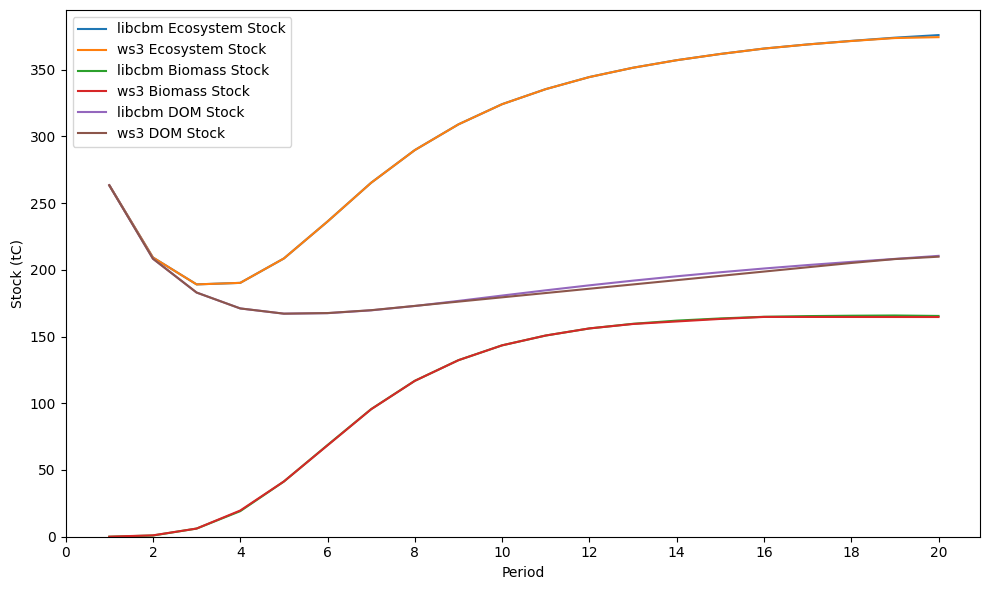

In [34]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon stock pools in the same graph
from util import compare_ws3_libcbm
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='whole', filename='no_harvest_carbon_stock_whole.pdf')

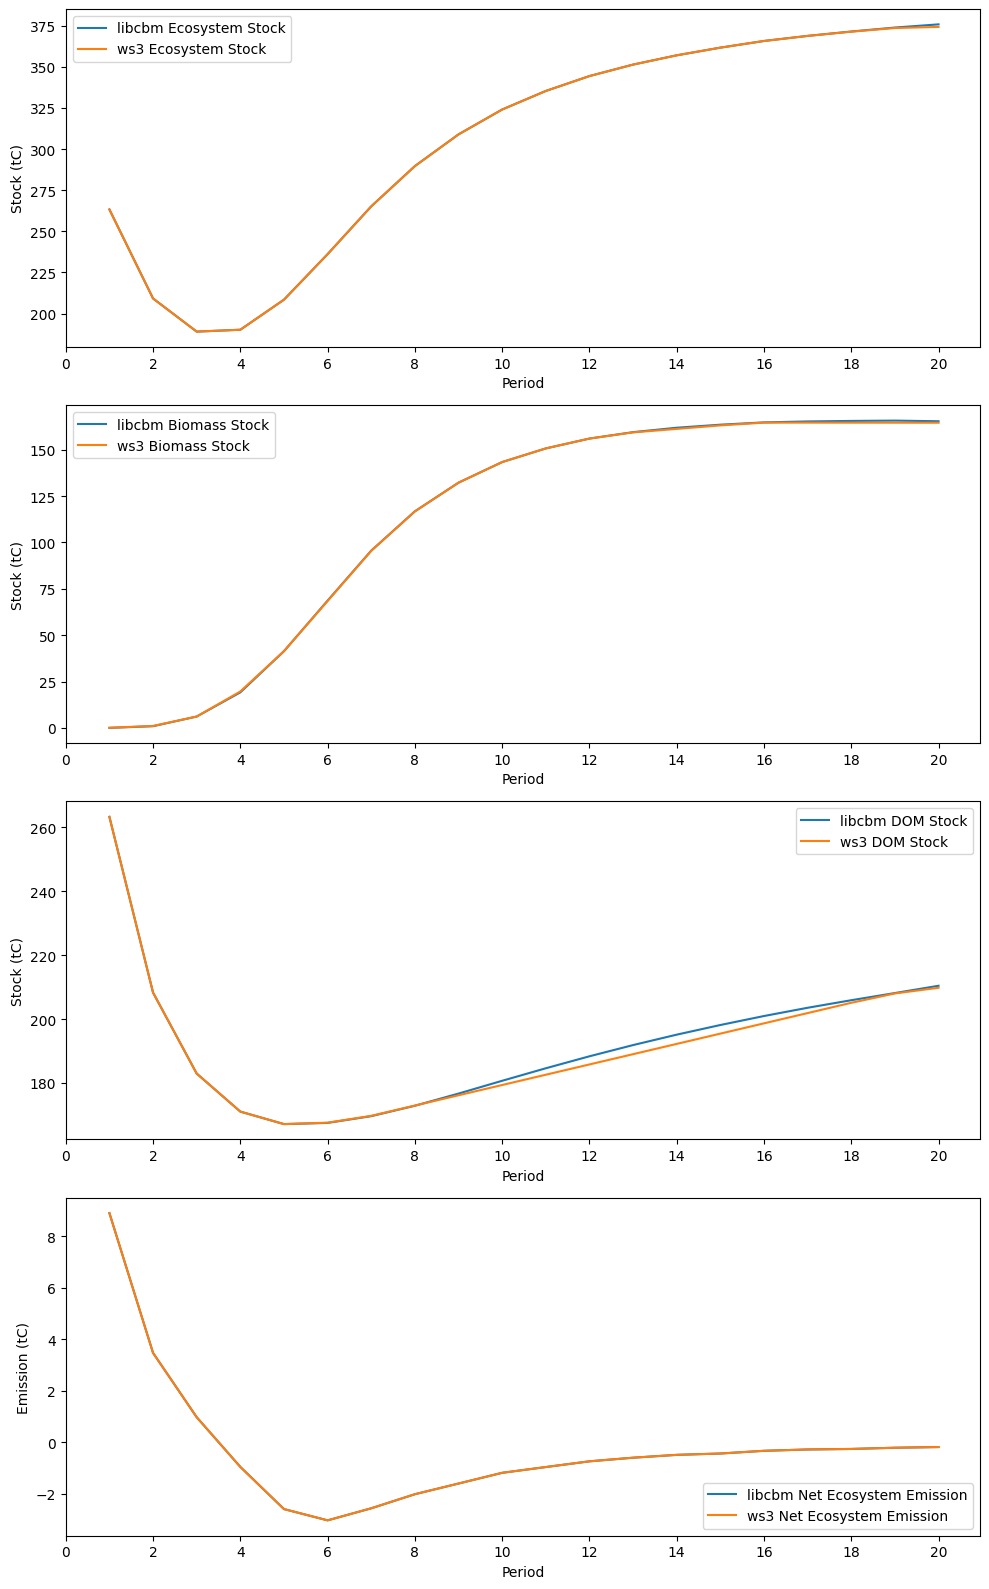

In [35]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon pools in individual graphs
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='individual', filename='no_harvest_carbon_dynamics_individual.pdf')

In [58]:
# Define the function to calculate percentage differences between carbon modelling outputs from ws3 and libcbm for each carbon pool (libcbm results are set as benchmark values for reference)
def pct_diff(df_ws3, df_cbm, timestep='period', metrics=None):
    
    if metrics is None:
        metrics = ['biomass_stock', 'dom_stock', 'eco_stock', 'net_emission']
    
    a = df_ws3.set_index(timestep)[metrics]
    b = df_cbm .set_index(timestep)[metrics]
    
    diff = (a - b).div(b).mul(100)
    
    return diff.reset_index()

In [59]:
df_diff = pct_diff(df_ws3, df_cbm)
df_diff

,period,biomass_stock,dom_stock,eco_stock,net_emission
0,1,1.422190e+03,0.000000,0.000000,0.000000e+00
1,2,1.390474e+01,0.000000,0.000000,-1.280148e-14
2,3,0.000000e+00,0.000000,0.000000,4.554816e-14
3,4,0.000000e+00,48.787039,48.786952,1.863515e+02
4,5,1.774041e+01,30.481401,30.353640,1.888244e+02
5,6,1.440492e+00,21.953887,21.213785,1.802512e+03
6,7,3.229403e+00,17.290120,15.450974,-4.317841e+01
7,8,0.000000e+00,60.629222,60.629105,1.282024e+02
8,9,1.774041e+01,45.182638,44.972020,1.737136e+02
9,10,1.440492e+00,36.548512,35.174492,-8.773902e+03


#### Schedule Havrests

Under this scenario, different combinations of harvesting activities can be applied to the forest stand to assess their impact on stand-level carbon dynamics

Here is an example of four clear-cuts applied on the forest stand at different times

In [38]:
sch =[(('tsa24', '1', '2403002', '204', '2423002'), 31, 1.0, 'harvest', 4, '_existing'),
      (('tsa24', '1', '2403002', '204', '2423002'), 40, 1.0, 'harvest', 8, '_existing'),
      (('tsa24', '1', '2403002', '204', '2423002'), 50, 1.0, 'harvest', 13, '_existing'),
      (('tsa24', '1', '2403002', '204', '2423002'), 60, 1.0, 'harvest', 19, '_existing')]

In [39]:
fm.apply_schedule(sch, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

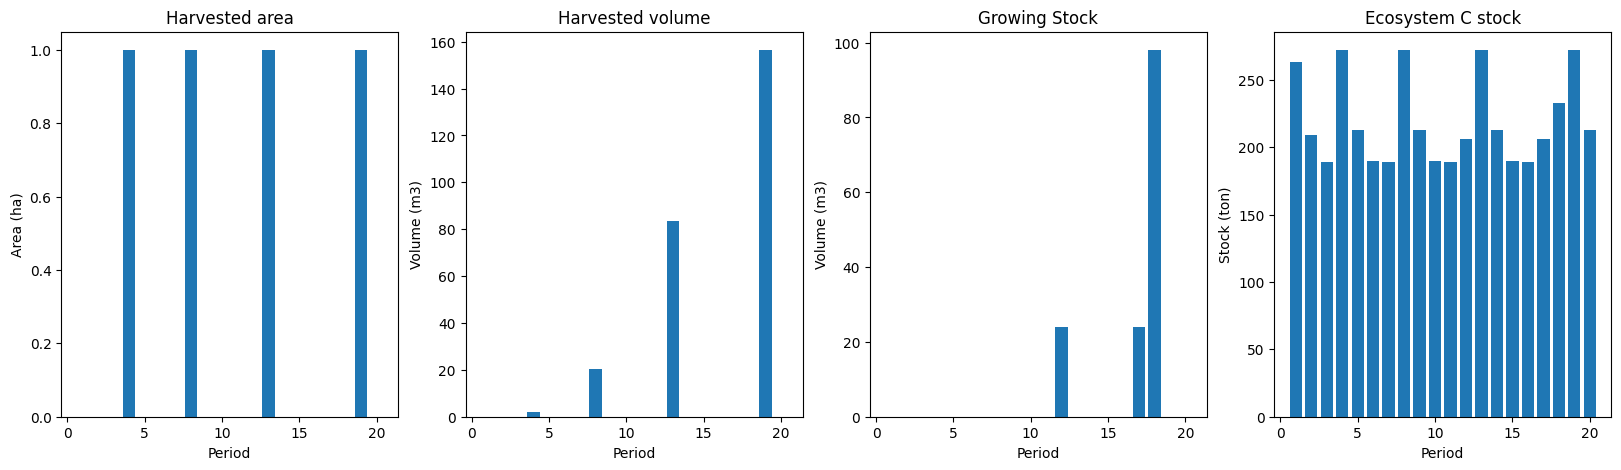

In [40]:
df_harvest = compile_scenario(fm)
fig, ax = plot_scenario(df_harvest)

In [41]:
#Import Modulaa
from util import compile_events

In [42]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [43]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [44]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [45]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,31
1,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,71
2,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,121
3,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,181


In [46]:
# Run CBM and Generate CBM Ouputs
cbm_output_harvest = run_cbm(sit_config, sit_tables, n_steps)

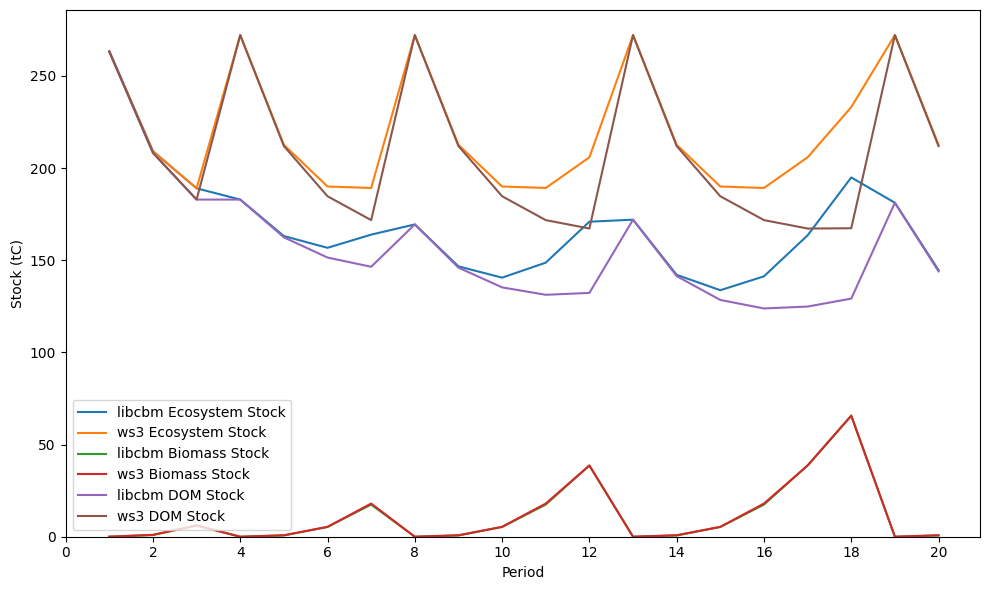

In [47]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon stock pools in the same graph
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='whole', filename='maximize_harvest_carbon_stock_whole.pdf')

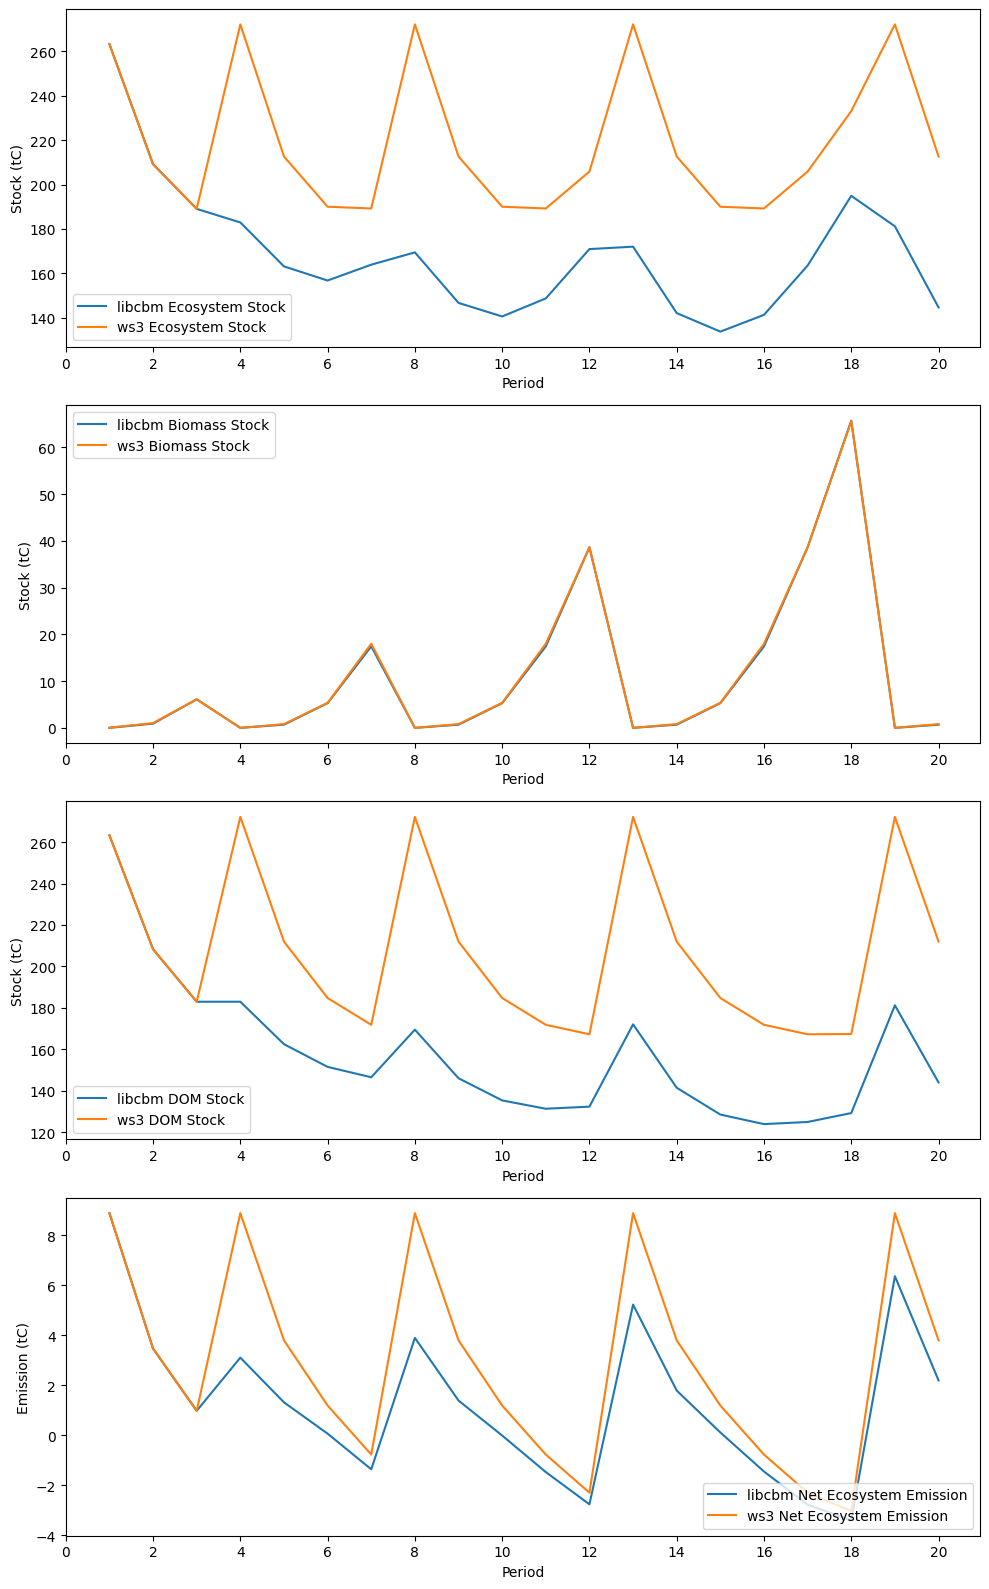

In [48]:
# Compare ws3 and libcbm carbon modelling outputs for different carbon pools in individual graphs
df_cbm, df_ws3 = compare_ws3_libcbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, plots='individual', filename='maximize_harvest_carbon_dynamics_individual.pdf')

In [49]:
df_ws3

,period,biomass_stock,dom_stock,eco_stock,net_emission
0,1,0.045408,263.297469,263.300452,8.892317
1,2,1.027134,208.283756,209.185505,3.469045
2,3,6.110762,182.938737,189.049499,0.974988
3,4,0.000327,272.192442,272.192769,8.892317
4,5,0.805080,211.970774,212.654550,3.798048
5,6,5.361044,184.739572,190.024487,1.187684
6,7,17.997798,171.797548,189.232308,-0.775925
7,8,0.000327,272.192442,272.192769,8.892317
8,9,0.805080,211.970774,212.654550,3.798048
9,10,5.361044,184.739572,190.024487,1.187684


In [50]:
df_cbm

,period,biomass_stock,dom_stock,eco_stock,total_emission,gross_growth,net_emission
0,1,0.002983,263.297469,263.300452,8.895193,0.002875,8.892317
1,2,0.901748,208.283756,209.185505,3.770192,0.301147,3.469045
2,3,6.110762,182.938737,189.049499,2.297960,1.322972,0.974988
3,4,0.000327,182.940963,182.941290,3.105734,0.000349,3.105385
4,5,0.683776,162.452865,163.136641,1.557814,0.242812,1.315003
5,6,5.284915,151.483136,156.768051,1.246969,1.184542,0.062427
6,7,17.434760,146.472310,163.907069,1.477771,2.843317,-1.365546
7,8,0.000327,169.453875,169.454202,3.897029,0.000349,3.896681
8,9,0.683776,146.002840,146.686615,1.630411,0.242812,1.387599
9,10,5.284915,135.292263,140.577178,1.170849,1.184542,-0.013693


In [51]:
# Calculate percentage differences between carbon modelling outputs from ws3 and libcbm for each carbon pool (libcbm results are set as benchmark values for reference)
df_diff = pct_diff(df_ws3, df_cbm)
df_diff

,period,biomass_stock,dom_stock,eco_stock,net_emission
0,1,1.422190e+03,0.000000,0.000000,0.000000e+00
1,2,1.390474e+01,0.000000,0.000000,-1.280148e-14
2,3,0.000000e+00,0.000000,0.000000,4.554816e-14
3,4,0.000000e+00,48.787039,48.786952,1.863515e+02
4,5,1.774041e+01,30.481401,30.353640,1.888244e+02
5,6,1.440492e+00,21.953887,21.213785,1.802512e+03
6,7,3.229403e+00,17.290120,15.450974,-4.317841e+01
7,8,0.000000e+00,60.629222,60.629105,1.282024e+02
8,9,1.774041e+01,45.182638,44.972020,1.737136e+02
9,10,1.440492e+00,36.548512,35.174492,-8.773902e+03
